# Predicting GPA with Deep Learning
This notebook reproduces the models and all figures and tables contained in my paper on the Fragile Familes Challenge.

***Please note the following if you intend to run this notebook***

- To the best of my knowledge this notebook will reproduce all the results accurately but due to stochastic nature of many of the processes used the results may differ. Where possible I have created static copies of objects that can be loaded directly. Some of these are too large to store on Github, for example the pickled versions of the final 5 classifiers. Please email me directly if you would like copies of these.

- This notebook is contains process that are computationally intensive and take some time to run. As is it will take at least 24 hours to run on a top spec laptop computer. I have noted the cells that take most time to run. If possible you may consider editing the notebook where appropriate to run processes in paraellel or using a GPU, although this may impact reproducibility.




# Loading packages and data

In [1]:
# Set up to ensure reproducibility following https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import tensorflow as tf
import numpy as np
import random
import os

os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(67891)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(54321)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(56789)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

seed = 13579 # used below to seed sklearn functions

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping, CSVLogger, History
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Loading the files

***Note: These data cannot be provided on Github and I will delete my copies in accordance with the FFC agreement. If you would like copies of the data to replicate these analyses please consult the Fragile Families and Child Wellbeing Survey [website](https://fragilefamilies.princeton.edu/documentation).***

In [2]:
train=pd.read_csv('../../../FFChallenge_v2/train.csv',low_memory=False, index_col='challengeID')
predictions=pd.read_csv('../../../FFChallenge_v2/prediction.csv',low_memory=False, index_col='challengeID')

To generate a version of the data with missing values imputed (`full_imputed.csv`) the script `clean_files.py` must first be run. If necessary it can be executed by uncommenting (deleting the #) and running the line below. ***This script will take approximately 30 minutes to run. It only needs to be run once.***

In [3]:
#! PYTHONHASHSEED=0 python3 ../preprocess/clean_files.py

In [4]:
data = pd.read_csv('../../data/full_imputed.csv') # load imputed data output after running the clean_files.py

In [5]:
data.shape

(4242, 4569)

In [6]:
data.index = data['challengeID']
del data['challengeID']

In [7]:
data.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag,hv4mompreg,hv4selfht,hv4selfwt,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,,,,,,,,,,,,,,,,
1,40.0,202.485367,25.0,6.723174,13.260396,38.0,1682.415602,0.038262,2.211822,29579.694329,...,0.0,0.0,0.0,0.0,2.5,3.50,0.090909,0.0,0.0,0.0
2,40.0,45.608219,43.0,16.000000,3.000000,25.0,3050.504448,0.110909,1.985703,20829.093487,...,0.0,1.0,0.0,0.0,2.5,3.25,0.181818,0.0,0.0,0.0
3,35.0,39.060299,49.0,46.000000,23.000000,20.0,0.000000,12.158179,1.386592,132483.450592,...,0.0,0.0,0.0,0.0,2.5,3.00,0.000000,0.0,0.0,0.0
4,30.0,22.304855,23.0,23.169628,5.699719,20.0,0.000000,4.165048,1.157385,0.000000,...,0.0,0.0,0.0,0.0,2.5,3.50,0.090909,0.0,0.0,0.0
5,25.0,35.518272,90.0,64.000000,58.000000,12.0,1974.812374,12.212538,2.965919,49026.982561,...,0.0,0.0,0.0,0.0,2.5,3.50,0.090909,0.0,0.0,0.0


Extract the outcomes from the imputed data.

In [8]:
y = data[['gpa','grit','materialHardship','eviction','layoff','jobTraining']]
X = data
for c in X.columns:
    if c in list(y.columns):
        del X[c]

# Data processing

Before modelling the data there are two types of transformations that I use to optimize them for the neural network.

Categorical variables are transformed using one-hot encoding. Continuous variables are also normalized to have a mean of zero.

To identify which columns belong to which group I use same heuristic as in the imputation script.

In [9]:
# Identify categorical columns
cat_cols = []
non_cat_cols = []
for i, c in enumerate(X.columns):
    is_categorical = False
    vals = set(list(X[c]))
    vals = {x for x in vals if x==x} # Removes nans, otherwise treated as unique
    if X[c].dtype == 'float64': # if float and low num distinct then treat as cat
        if len(vals) <= 20:
            is_categorical = True
        else:
            pass
    else:
        is_categorical = True
    
    # Now append to relevant list of columns
    if is_categorical:
        cat_cols.append(c)
        
    else:
        non_cat_cols.append(c)

In [10]:
X_dummies = pd.get_dummies(X, columns=cat_cols)
# Note that sklearn also has one-hot encoding but doesn't relabel

In [11]:
X_dummies.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag_1.0,hv4mflag_2.0,hv4mflag_3.0,hv4mompreg_0.0,hv4mompreg_1.0,hv4selfht_0.0,hv4selfht_1.0,hv4selfht_2.0,hv4selfwt_0.0,hv4selfwt_1.0
challengeID,,,,,,,,,,,,,,,,,,,,,
1,40.0,202.485367,25.0,6.723174,13.260396,38.0,1682.415602,0.038262,2.211822,29579.694329,...,0,0,0,1,0,1,0,0,1,0
2,40.0,45.608219,43.0,16.000000,3.000000,25.0,3050.504448,0.110909,1.985703,20829.093487,...,0,0,0,0,1,1,0,0,1,0
3,35.0,39.060299,49.0,46.000000,23.000000,20.0,0.000000,12.158179,1.386592,132483.450592,...,0,0,0,1,0,1,0,0,1,0
4,30.0,22.304855,23.0,23.169628,5.699719,20.0,0.000000,4.165048,1.157385,0.000000,...,0,0,0,1,0,1,0,0,1,0
5,25.0,35.518272,90.0,64.000000,58.000000,12.0,1974.812374,12.212538,2.965919,49026.982561,...,0,0,0,1,0,1,0,0,1,0


In [12]:
normalizer = StandardScaler()
for c in non_cat_cols:
    normed = normalizer.fit_transform(X_dummies[c].values.reshape(-1,1))
    X_dummies[c] = normed

In [13]:
X_dummies.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag_1.0,hv4mflag_2.0,hv4mflag_3.0,hv4mompreg_0.0,hv4mompreg_1.0,hv4selfht_0.0,hv4selfht_1.0,hv4selfht_2.0,hv4selfwt_0.0,hv4selfwt_1.0
challengeID,,,,,,,,,,,,,,,,,,,,,
1,0.364267,0.675623,-0.545055,-0.788818,0.183309,0.255698,-0.245954,-1.512365,0.017524,-0.105330,...,0,0,0,1,0,1,0,0,1,0
2,0.364267,-0.197911,0.606432,-0.149595,-1.041256,-0.986483,-0.080941,-1.497946,-0.168142,-0.377045,...,0,0,0,0,1,1,0,0,1,0
3,-0.071568,-0.234372,0.990261,1.917563,1.345718,-1.464245,-0.448880,0.893159,-0.660072,3.089933,...,0,0,0,1,0,1,0,0,1,0
4,-0.507403,-0.327670,-0.672998,0.344430,-0.719048,-1.464245,-0.448880,-0.693293,-0.848273,-1.023809,...,0,0,0,1,0,1,0,0,1,0
5,-0.943238,-0.254094,3.613094,3.157858,5.522921,-2.228664,-0.210687,0.903948,0.636712,0.498527,...,0,0,0,1,0,1,0,0,1,0


In [14]:
X = X_dummies # rename X

Now splitting the X and y matrices to separate cases in the training set and the prediction set.

In [15]:
X_training=X.loc[X.index.isin(train.index)]
X_pred=X.loc[~X.index.isin(train.index)]

In [16]:
y_training=y.loc[y.index.isin(train.index)]
y_pred=y.loc[~y.index.isin(train.index)]

# Modeling

Randomly splitting the data into training and test sets, where 20% of data is held out for validation and testing. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training.gpa, test_size=0.20, random_state=seed)

In [47]:
# Storing these files for later
X_test.to_csv('../../data/X_test.csv')
pd.Series(cat_cols).to_csv('../../data/cat_cols.csv')

Making a function that can be used to return Keras models with different parameter combinations.

In [19]:
def make_model(activation_function, num_hidden_layers, hidden_layer_size):
    '''
    A function to create a Keras sequential model based on input parameters.
    
    Parameters
    -----------
        activation_function: str
            Activation function to be used in model.
        
        num_hidden_layers: int
            Number of hidden layers in model
        
        hidden_layer_size: int
            Number of units/neurons in each hidden layer
            
    Returns
    ---------
    
    Keras Sequential model object
    
    '''
    
    model = Sequential()
    
    
    # Single layer model
    if num_hidden_layers == 0: # then just specify a single layer, 1 is size of output
        model.add(Dense(1, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True,
                        kernel_initializer=glorot_uniform(seed=seed)
                      ))
        
        model.add(Dropout(0.5))
    
    # Specify initial layer with a hidden layer
    if num_hidden_layers >= 1: 
        model.add(Dense(hidden_layer_size, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True,
                        kernel_initializer=glorot_uniform(seed=seed)
                       ))
        model.add(Dropout(0.5))
    
    # Now add additional hidden layers
    for i in range(0,num_hidden_layers-1):
        model.add(Dense(hidden_layer_size, 
                        activation=activation_function, 
                        use_bias=True,
                        kernel_initializer=glorot_uniform(seed=seed)
                       ))
        model.add(Dropout(0.5))
    
    if num_hidden_layers > 0:       
        model.add(Dense(1)) # Final output layer, don't add if no hidden layers

    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    return model

Now I take the model object and use it to initialize a classifier using the scikit-learn Keras wrapped object `KerasRegressor`.

I then define the parameter space to search over and pass both to a `GridSearchCV` object. 

Once the `fit` method is called the grid search will begin and a model will fit for every parameter combination and fold (40 x 5). 

***Note: This will take 12 hours or more to complete***


In [20]:
%%time


classifier = KerasRegressor(make_model, batch_size=32, epochs=200)

# params = [{'num_hidden_layers': [0],
#           'hidden_layer_size': [0],
#           'activation_function': ['linear', 'sigmoid', 'relu', 'tanh']},
#           {'num_hidden_layers': [1,2,3],
#           'hidden_layer_size': [64, 128, 256],
#           'activation_function': ['linear', 'sigmoid', 'relu', 'tanh']}]

params = [{'num_hidden_layers': [2],
          'hidden_layer_size': [64],
          'activation_function': ['tanh']}]


grid = GridSearchCV(classifier,
                         param_grid=params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=KFold(n_splits=5, shuffle=True, random_state=42),# Number of folds for CV
                         return_train_score=True,
                         error_score='raise'
                   )

grid.fit(np.array(X_train), np.array(y_train),
        **{'callbacks': [EarlyStopping(monitor='val_loss', 
                                                                 min_delta=0.001, 
                                                                 patience=25, 
                                                                 mode='min',
                                                                 verbose=2)],
                                    'validation_data': (np.array(X_test), np.array(y_test))
                                    })

print('The parameters of the best model are: ')
print(grid.best_params_)

best_model = grid.best_estimator_ #scikit-wrapped best model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 1s 908us/step - loss: 2.1338 - val_loss: 0.4148
Epoch 2/200
1356/1356 [==============================] - 1s 613us/step - loss: 1.5126 - val_loss: 0.6434
Epoch 3/200
1356/1356 [==============================] - 1s 633us/step - loss: 1.2666 - val_loss: 0.7307
Epoch 4/200
1356/1356 [==============================] - 1s 583us/step - loss: 1.1299 - val_loss: 0.7382
Epoch 5/200
1356/1356 [==============================] - 1s 582us/step - loss: 1.0447 - val_loss: 0.6972
Epoch 6/200
1356/1356 [==============================] - 1s 620us/step - loss: 0.9432 - val_loss: 1.1264
Epoch 7/200
1356/1356 [==============================] - 1s 613us/step - loss: 0.8394 - val_loss: 0.9135
Epoch 8/200
1356/1356 [==============================] - 1s 613us/step - loss: 0.7951 - val_loss: 0.8134
Epoch 9/200
1356/1356 [==============================] - 1s 609us/step - loss: 0.7321 - val_loss: 0.8836
Epoch 10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.4s remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 1s 856us/step - loss: 1.7802 - val_loss: 0.4941
Epoch 2/200
1357/1357 [==============================] - 1s 573us/step - loss: 1.3153 - val_loss: 0.9173
Epoch 3/200
1357/1357 [==============================] - 1s 577us/step - loss: 1.1157 - val_loss: 0.7246
Epoch 4/200
1357/1357 [==============================] - 1s 573us/step - loss: 0.9828 - val_loss: 0.7033
Epoch 5/200
1357/1357 [==============================] - 1s 643us/step - loss: 0.9046 - val_loss: 0.9277
Epoch 6/200
1357/1357 [==============================] - 1s 624us/step - loss: 0.8063 - val_loss: 0.9745
Epoch 7/200
1357/1357 [==============================] - 1s 607us/step - loss: 0.7170 - val_loss: 0.7623
Epoch 8/200
1357/1357 [==============================] - 1s 598us/step - loss: 0.6844 - val_loss: 0.7032
Epoch 9/200
1357/1357 [==============================] - 1s 560us/step - loss: 0.6440 - val_loss: 0.6174
Epoch 10

Epoch 25/200
1357/1357 [==============================] - 1s 640us/step - loss: 0.4267 - val_loss: 0.3083
Epoch 26/200
1357/1357 [==============================] - 1s 633us/step - loss: 0.4466 - val_loss: 0.3154
Epoch 27/200
1357/1357 [==============================] - 1s 606us/step - loss: 0.4130 - val_loss: 0.3028
Epoch 28/200
1357/1357 [==============================] - 1s 626us/step - loss: 0.4119 - val_loss: 0.3106
Epoch 29/200
1357/1357 [==============================] - 1s 637us/step - loss: 0.4197 - val_loss: 0.3103
Epoch 30/200
1357/1357 [==============================] - 1s 614us/step - loss: 0.4210 - val_loss: 0.3092
Epoch 31/200
1357/1357 [==============================] - 1s 617us/step - loss: 0.4024 - val_loss: 0.3031
Epoch 32/200
1357/1357 [==============================] - 1s 626us/step - loss: 0.4119 - val_loss: 0.3009
Epoch 33/200
1357/1357 [==============================] - 1s 653us/step - loss: 0.4060 - val_loss: 0.3056
Epoch 34/200
1357/1357 [======================

1357/1357 [==============================] - 1s 561us/step - loss: 0.2906 - val_loss: 0.2955
Epoch 103/200
1357/1357 [==============================] - 1s 614us/step - loss: 0.3137 - val_loss: 0.2897
Epoch 104/200
1357/1357 [==============================] - 1s 639us/step - loss: 0.3085 - val_loss: 0.2803
Epoch 105/200
1357/1357 [==============================] - 1s 639us/step - loss: 0.3121 - val_loss: 0.2909
Epoch 106/200
1357/1357 [==============================] - 1s 634us/step - loss: 0.3105 - val_loss: 0.3052
Epoch 107/200
1357/1357 [==============================] - 1s 641us/step - loss: 0.3077 - val_loss: 0.2761
Epoch 108/200
1357/1357 [==============================] - 1s 638us/step - loss: 0.3095 - val_loss: 0.3310
Epoch 109/200
1357/1357 [==============================] - 1s 648us/step - loss: 0.3088 - val_loss: 0.2942
Epoch 110/200
1357/1357 [==============================] - 1s 637us/step - loss: 0.3118 - val_loss: 0.2854
Epoch 111/200
1357/1357 [==========================

Epoch 45/200
1357/1357 [==============================] - 1s 627us/step - loss: 0.4081 - val_loss: 0.3076
Epoch 46/200
1357/1357 [==============================] - 1s 661us/step - loss: 0.4074 - val_loss: 0.3084
Epoch 47/200
1357/1357 [==============================] - 1s 636us/step - loss: 0.4000 - val_loss: 0.3076
Epoch 48/200
1357/1357 [==============================] - 1s 650us/step - loss: 0.4063 - val_loss: 0.3080
Epoch 49/200
1357/1357 [==============================] - 1s 613us/step - loss: 0.4173 - val_loss: 0.3076
Epoch 50/200
1357/1357 [==============================] - 1s 619us/step - loss: 0.4219 - val_loss: 0.3180
Epoch 51/200
1357/1357 [==============================] - 1s 614us/step - loss: 0.3943 - val_loss: 0.3087
Epoch 52/200
1357/1357 [==============================] - 1s 678us/step - loss: 0.4075 - val_loss: 0.3120
Epoch 53/200
1357/1357 [==============================] - 1s 672us/step - loss: 0.4075 - val_loss: 0.3214
Epoch 54/200
1357/1357 [======================

1357/1357 [==============================] - 1s 639us/step - loss: 0.4198 - val_loss: 0.3086
Epoch 53/200
1357/1357 [==============================] - 1s 649us/step - loss: 0.3902 - val_loss: 0.3088
Epoch 54/200
1357/1357 [==============================] - 1s 632us/step - loss: 0.4021 - val_loss: 0.3145
Epoch 55/200
1357/1357 [==============================] - 1s 616us/step - loss: 0.3941 - val_loss: 0.3291
Epoch 56/200
1357/1357 [==============================] - 1s 655us/step - loss: 0.4130 - val_loss: 0.3076
Epoch 57/200
1357/1357 [==============================] - 1s 619us/step - loss: 0.3905 - val_loss: 0.3106
Epoch 58/200
1357/1357 [==============================] - 1s 610us/step - loss: 0.3894 - val_loss: 0.3099
Epoch 59/200
1357/1357 [==============================] - 1s 653us/step - loss: 0.4033 - val_loss: 0.3077
Epoch 60/200
1357/1357 [==============================] - 1s 648us/step - loss: 0.4101 - val_loss: 0.3116
Epoch 61/200
1357/1357 [==============================] - 1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 2s 1ms/step - loss: 1.8554 - val_loss: 0.3946
Epoch 2/200
1696/1696 [==============================] - 2s 916us/step - loss: 1.3672 - val_loss: 0.4912
Epoch 3/200
1696/1696 [==============================] - 2s 915us/step - loss: 1.1532 - val_loss: 0.5673
Epoch 4/200
1696/1696 [==============================] - 2s 886us/step - loss: 0.9767 - val_loss: 0.8649
Epoch 5/200
1696/1696 [==============================] - 1s 832us/step - loss: 0.8672 - val_loss: 0.7874
Epoch 6/200
1696/1696 [==============================] - 2s 962us/step - loss: 0.7175 - val_loss: 0.8603
Epoch 7/200
1696/1696 [==============================] - 1s 874us/step - loss: 0.6594 - val_loss: 0.6190
Epoch 8/200
1696/1696 [==============================] - 2s 928us/step - loss: 0.6650 - val_loss: 0.6666
Epoch 9/200
1696/1696 [==============================] - 2s 945us/step - loss: 0.6261 - val_loss: 0.5357
Epoch 10/2

In [21]:
grid.best_params_

{'activation_function': 'tanh',
 'hidden_layer_size': 64,
 'num_hidden_layers': 2}

The scores can the be extracted to view performance of every model on every fold.

In [22]:
results = pd.DataFrame(grid.cv_results_)

In [23]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_activation_function', 'param_hidden_layer_size',
       'param_num_hidden_layers', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [24]:
results.sort_values(['rank_test_score'], ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_function,param_hidden_layer_size,param_num_hidden_layers,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,69.772343,28.543953,0.110753,0.021249,tanh,64,2,"{'activation_function': 'tanh', 'hidden_layer_...",-0.331345,-0.303178,...,-0.314166,0.013047,1,-0.314232,-0.321803,-0.174878,-0.321403,-0.31434,-0.289331,0.05732


The best performing models (based on the grid-search) can then be identified.

In [25]:
grouped = results.groupby(['param_num_hidden_layers','param_hidden_layer_size','param_activation_function'])
grouped = grouped.mean()
grouped

,,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
param_num_hidden_layers,param_hidden_layer_size,param_activation_function,,,,,,,,,,,,,,,,,,,
2,64,tanh,69.772343,28.543953,0.110753,0.021249,-0.331345,-0.303178,-0.295473,-0.318396,-0.322387,-0.314166,0.013047,1,-0.314232,-0.321803,-0.174878,-0.321403,-0.31434,-0.289331,0.05732


In [27]:
grouped.to_csv('../../output/model_params_and_results.csv') # Save csv so it can be used as a table in the paper

I find the top 5 best performing models and look more closely at their performance. 

Note that they all have very similar scores, all of which are far better than we would expect (none of the leaderboard scores are better than 0.38). This suggests that there is some overfitting in these models, despite the use of dropout, cross-validation, and early stopping using validation loss.

In [28]:
best = grouped.sort_values(['rank_test_score'],ascending=True).head(5)
best

,,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
param_num_hidden_layers,param_hidden_layer_size,param_activation_function,,,,,,,,,,,,,,,,,,,
2,64,tanh,69.772343,28.543953,0.110753,0.021249,-0.331345,-0.303178,-0.295473,-0.318396,-0.322387,-0.314166,0.013047,1,-0.314232,-0.321803,-0.174878,-0.321403,-0.31434,-0.289331,0.05732


In [29]:
final_models = []
for _, r in best.iterrows():
    p = {'num_hidden_layers': [_[0]],
          'hidden_layer_size': [_[1]],
          'activation_function': [_[2]]}
    final_models.append(p)

Now to retrain the 5 best models and assess the out-of-sample performance of each.

I can use the same gridsearch with a single set of parameters to iterate over the models and get predictions. The only changes I'm making are the inclusion of additional callback parameters to store the results and a slight decrease in the `patience` parameter to help prevent overfitting.

This time I also store each estimator, its predictions, and its history in a dictionary.

***Note: It takes at least 2 hours to run these models.***

In [30]:
# Setting seeds again to ensure reproducibility
np.random.seed(67891)
random.seed(54321)
tf.set_random_seed(56789)

In [36]:
%%time
model_info = {}
for i, p in enumerate(final_models):
    history = History() # History callback
    model_name = 'model_'+str(i+1)
    classifier = KerasRegressor(make_model, batch_size=32, epochs=200)
    grid = GridSearchCV(classifier,
                             param_grid=p,
                             scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                             n_jobs=1,
                             verbose=2,
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),# Number of folds for CV
                             return_train_score=True
                       )

    grid.fit(np.array(X_train), np.array(y_train),
            **{'callbacks': [EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0.001, 
                                                                     patience=20,
                                                                     mode='min',
                                                                     verbose=2),
                                                      CSVLogger('../../output/logs/'+model_name+'.csv', separator=',', append=True),
                                                      history], # Added a history callback
                                        'validation_data': (np.array(X_test), np.array(y_test))
                                        })
    y_hats = grid.predict(np.array(X_test))
    print("Out-of-sample MSE: ", mean_squared_error(y_test, y_hats))
    y_hats_full = grid.predict(np.array(X))
    model_info[model_name] = {'grid_obj': grid,
                              'keras_model': grid.best_estimator_.model,
                              'preds': y_hats_full,
                              'history': history.history}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 2s 1ms/step - loss: 1.7378 - val_loss: 0.4423
Epoch 2/200
1356/1356 [==============================] - 1s 558us/step - loss: 1.3455 - val_loss: 1.1612
Epoch 3/200
1356/1356 [==============================] - 1s 549us/step - loss: 1.2217 - val_loss: 0.6494
Epoch 4/200
1356/1356 [==============================] - 1s 562us/step - loss: 1.0463 - val_loss: 1.0708
Epoch 5/200
1356/1356 [==============================] - 1s 564us/step - loss: 0.9283 - val_loss: 0.8284
Epoch 6/200
1356/1356 [==============================] - 1s 573us/step - loss: 0.7949 - val_loss: 0.7453
Epoch 7/200
1356/1356 [==============================] - 1s 613us/step - loss: 0.7159 - val_loss: 0.6420
Epoch 8/200
1356/1356 [==============================] - 1s 555us/step - loss: 0.7050 - val_loss: 0.6250
Epoch 9/200
1356/1356 [==============================] - 1s 548us/step - loss: 0.6242 - val_loss: 0.5742
Epoch 10/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.9s remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.2460 - val_loss: 0.8689
Epoch 2/200
1357/1357 [==============================] - 1s 657us/step - loss: 1.3847 - val_loss: 0.6765
Epoch 3/200
1357/1357 [==============================] - 1s 657us/step - loss: 1.2661 - val_loss: 0.8481
Epoch 4/200
1357/1357 [==============================] - 1s 658us/step - loss: 1.0766 - val_loss: 0.7157
Epoch 5/200
1357/1357 [==============================] - 1s 650us/step - loss: 0.9507 - val_loss: 0.9514
Epoch 6/200
1357/1357 [==============================] - 1s 668us/step - loss: 0.9111 - val_loss: 0.8833
Epoch 7/200
1357/1357 [==============================] - 1s 666us/step - loss: 0.8436 - val_loss: 0.7549
Epoch 8/200
1357/1357 [==============================] - 1s 684us/step - loss: 0.8118 - val_loss: 0.7240
Epoch 9/200
1357/1357 [==============================] - 1s 652us/step - loss: 0.7034 - val_loss: 0.7206
Epoch 10/2

Epoch 22/200
1357/1357 [==============================] - 1s 804us/step - loss: 0.4472 - val_loss: 0.3193
Epoch 23/200
1357/1357 [==============================] - 1s 811us/step - loss: 0.4410 - val_loss: 0.3234
Epoch 24/200
1357/1357 [==============================] - 1s 793us/step - loss: 0.4509 - val_loss: 0.3179
Epoch 25/200
1357/1357 [==============================] - 1s 913us/step - loss: 0.4569 - val_loss: 0.3126
Epoch 26/200
1357/1357 [==============================] - 1s 802us/step - loss: 0.4531 - val_loss: 0.3265
Epoch 27/200
1357/1357 [==============================] - 1s 877us/step - loss: 0.4597 - val_loss: 0.3076
Epoch 28/200
1357/1357 [==============================] - 1s 773us/step - loss: 0.4404 - val_loss: 0.3086
Epoch 29/200
1357/1357 [==============================] - 1s 817us/step - loss: 0.4534 - val_loss: 0.3108
Epoch 30/200
1357/1357 [==============================] - 1s 954us/step - loss: 0.4491 - val_loss: 0.3080
Epoch 31/200
1357/1357 [======================

1357/1357 [==============================] - 1s 803us/step - loss: 0.3961 - val_loss: 0.3076
Epoch 51/200
1357/1357 [==============================] - 1s 706us/step - loss: 0.3995 - val_loss: 0.3145
Epoch 52/200
1357/1357 [==============================] - 1s 678us/step - loss: 0.4121 - val_loss: 0.3080
Epoch 53/200
1357/1357 [==============================] - 1s 628us/step - loss: 0.4045 - val_loss: 0.3154
Epoch 00053: early stopping
[CV]  activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2, total=  51.9s
[CV] activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.0450 - val_loss: 0.8345
Epoch 2/200
1357/1357 [==============================] - 1s 654us/step - loss: 1.3535 - val_loss: 0.6536
Epoch 3/200
1357/1357 [==============================] - 1s 634us/step - loss: 1.1879 - val_loss: 0.9440
Epoch 4/200
1357/1357 [===============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 3s 2ms/step - loss: 1.7650 - val_loss: 0.5314
Epoch 2/200
1696/1696 [==============================] - 2s 1ms/step - loss: 1.3144 - val_loss: 0.6059
Epoch 3/200
1696/1696 [==============================] - 2s 1ms/step - loss: 1.0397 - val_loss: 0.8929
Epoch 4/200
1696/1696 [==============================] - 2s 1ms/step - loss: 0.9217 - val_loss: 0.7817
Epoch 5/200
1696/1696 [==============================] - 2s 1ms/step - loss: 0.8215 - val_loss: 0.8265
Epoch 6/200
1696/1696 [==============================] - 2s 1ms/step - loss: 0.7355 - val_loss: 0.6292
Epoch 7/200
1696/1696 [==============================] - 2s 1ms/step - loss: 0.6849 - val_loss: 0.7167
Epoch 8/200
1696/1696 [==============================] - 2s 1ms/step - loss: 0.6497 - val_loss: 0.6692
Epoch 9/200
1696/1696 [==============================] - 2s 1ms/step - loss: 0.5960 - val_loss: 0.6133
Epoch 10/200
1696/1696 [==

In [37]:
model_info

{'model_1': {'grid_obj': GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
         error_score='raise-deprecating',
         estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x15b6a6e48>,
         fit_params=None, iid='warn', n_jobs=1,
         param_grid={'num_hidden_layers': [2], 'hidden_layer_size': [64], 'activation_function': ['tanh']},
         pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
         scoring='neg_mean_squared_error', verbose=2),
  'keras_model': <keras.engine.sequential.Sequential at 0x15f469ef0>,
  'preds': array([2.8838518, 2.883857 , 2.883857 , ..., 2.883857 , 2.883857 ,
         2.883857 ], dtype=float32),
  'history': {'val_loss': [0.5313826993633719,
    0.6059455791641685,
    0.8929229417969199,
    0.7817382983600392,
    0.8265372492285336,
    0.6292406084958245,
    0.7166805403372821,
    0.6691630902009852,
    0.6132755932387184,
    0.4769882801701041,
    0.5428759325953091,
    0.41675986093633316,
 

In [38]:
histories = {k:v['history'] for k,v in model_info.items()}

In [40]:
pickle.dump(histories, open('../../output/model_histories.p','wb')) # Storing for later

# Model evaluation

To assess how the different models performed we can plot their performance on the training and test set at each epoch in the learning process. Since the first couple of epochs generally have a very high loss (thus increasing the size of the y-axis and obscuring the future epochs) I present the learn from the results from the second epoch onwards.

{'num_hidden_layers': [2], 'hidden_layer_size': [64], 'activation_function': ['tanh']}


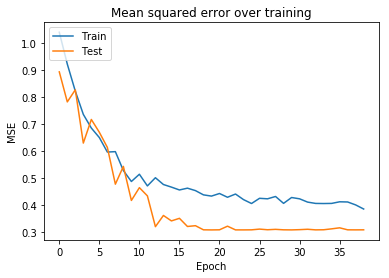

In [41]:
for i, k in enumerate(list(model_info.keys())): 
    print(final_models[i])
    plt.plot(model_info[k]['history']['loss'][2:])
    plt.plot(model_info[k]['history']['val_loss'][2:])
    plt.title('Mean squared error over training')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

The first and third models both show evidence of overfitting, as training performance continued to improve as validation performance plateaued (as seen when the blue line goes below the orange line). This suggests that these models will perform worse on the out-of-sample data.

Now I store and upload the predictions of each model to obtain the results on the true held out data.

In [42]:
for i, k in enumerate(list(model_info.keys())):
    predictions['gpa'] = model_info[k]['preds']
    name = '../../output/final_predictions_model_'+str(i)+'.csv'
    predictions.to_csv(name)
    # csvs were then uploaded to the challenge website: https://codalab.fragilefamilieschallenge.org/#participate-submit_results

It is useful to compare to the predicted values for the test data.

In [43]:
# Printing performance on validation set
for k,v in model_info.items():
    print(mean_squared_error(y_test, v['grid_obj'].predict(np.array(X_test))))

0.30794313042794835


In [45]:
# Store all five model objects
for k,v in model_info.items():
    v['keras_model'].save('../../output/models/'+k+'.h5')